<a href="https://colab.research.google.com/github/bbhavii/Project-Work/blob/main/Image%20Analysis%20for%20Eye%20Disease%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing all the necessary packages.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
import PIL as image
import numpy as np
import pandas as pd
import imageio as iio
import cv2
from google.colab.patches import cv2_imshow
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading the DataFrame

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/full_df.csv') 
df["class_num"] = df["labels"].map({"['N']": 0, "['D']": 1, "['G']":2,"['C']":3,"['A']":4,"['H']":5,"['M']":6,"['O']":7})
display(df)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename,class_num
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,1
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg,1
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4686_left.jpg,1
6388,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4688_left.jpg,1
6389,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4689_left.jpg,1
6390,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4690_left.jpg,1


In [ ]:
https://drive.google.com/drive/folders/1hJ9dbImD3BwanrXV23j6OxSELBv3EtEN?usp=share_link

Preprocessing the images with sorting them in their class files.

In [ ]:

path = '/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/ODIR-5K/ODIR-5K/Training Images'
X_train_img = []
write_path = '/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/resized_images/'

def resizing_the_eye(img, size):
  width, height, ______ = img.shape
  if width == height:
      return cv2.resize(img, size)
  length = min(width, height)
  left = (width - length) // 2
  top = (height - length) // 2
  right = (width + length) // 2
  bottom = (height + length) // 2
  return cv2.resize(img[left:right, top:bottom, :], size)

#here the image is taken, resized and stored in a different file so as to not lose the original copy
for filename in df['filename'][1200:6390]:
  img_path = os.path.join(path,filename)
  write_path_save = os.path.join(write_path,filename)
  img = cv2.imread(img_path)
  rimg = resizing_the_eye(img, (64,64))
  cv2.imwrite(write_path_save,rimg)
  print(filename)


In [ ]:
path = '/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/ODIR-5K/ODIR-5K/Training Images'
X_train_img = []
write_path = '/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/resized_images/'

Getting the class distributions.

In [ ]:
def show_class_distribution():
  N = 0
  D=0
  G=0
  C=0
  A=0
  H=0
  M=0
  O = 0
  X = 0
  for index in df.index[:5800]:
    img_name = df['labels'][index]
    #print(img_name[2])
    img_label = img_name[2]
    if img_label == 'N':
      N += 1
    elif img_label == 'D':
      D +=1
    elif img_label == 'G':
      G +=1
    elif img_label == 'C':
      C +=1
    elif img_label== 'A':
      A +=1
    elif img_label == 'H':
      H +=1
    elif img_label == 'M':
      M +=1
    elif img_label == 'O':
      O +=1
    elif "&" in img_label[-1]:
      X +=1  
  print(N,',', D,',', G,',', C, ',',A, ',',H,',', M,',', O, X)
show_class_distribution()

2758 , 1140 , 284 , 293 , 266 , 119 , 232 , 708 0


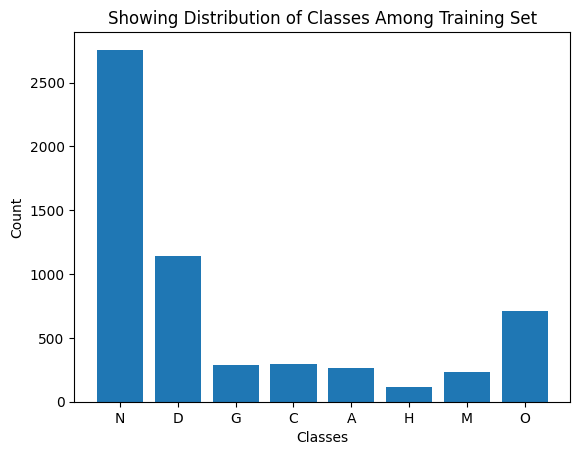

In [ ]:
classes = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
values = [2758 , 1140 , 284 , 293 , 266 , 119 , 232 , 708]
plt.bar(classes,values)
plt.title('Showing Distribution of Classes Among Training Set')
plt.xlabel("Classes")
plt.ylabel('Count')
plt.show();

Getting class weights to correct imbalance of samples in dataset.

In [ ]:
import numpy as np
import math

def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    
    return class_weight


labels_dict = {0: 2758, 1: 1140, 2: 284, 3: 293, 4: 266, 5: 119, 6: 232,7:708}

class_weight_1000 = create_class_weight(labels_dict)
print(class_weight_1000)

{0: 1.0, 1: 1.0, 2: 1.1195189734874234, 3: 1.0883206026315622, 4: 1.1849969028669305, 5: 1.9893697185371, 6: 1.3217558399823195, 7: 1.0}


Separating the data into a train and validation test set.

In [ ]:
write_path = '/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/resized_images/'
a = (str(df['labels'][10][2]))
Y_train = []
for label in df['labels'][:5200]:
  Y_train.append(str(label[2]))
print(Y_train)

Y_valid = []
for label in df['labels'][5200:]:
  Y_valid.append(str(label[2]))
print(Y_valid)

X_train = []
for filename in df['filename'][:5200]:
  X_train.append(os.path.join(write_path,filename))
print(X_train)

X_valid = []
for filename in df['filename'][5200:]:
  X_valid.append(os.path.join(write_path,filename))
print(X_valid)

['N', 'N', 'D', 'D', 'D', 'D', 'D', 'N', 'O', 'N', 'D', 'M', 'O', 'O', 'M', 'O', 'M', 'D', 'O', 'H', 'C', 'D', 'O', 'H', 'N', 'N', 'H', 'O', 'O', 'N', 'N', 'N', 'O', 'O', 'A', 'D', 'H', 'M', 'N', 'A', 'N', 'D', 'O', 'O', 'A', 'D', 'A', 'O', 'O', 'O', 'N', 'H', 'O', 'N', 'N', 'D', 'O', 'A', 'O', 'N', 'N', 'O', 'O', 'N', 'D', 'D', 'O', 'O', 'N', 'O', 'M', 'D', 'O', 'D', 'D', 'O', 'D', 'O', 'H', 'D', 'O', 'N', 'N', 'N', 'O', 'A', 'N', 'N', 'M', 'D', 'N', 'N', 'D', 'C', 'O', 'N', 'N', 'H', 'O', 'D', 'O', 'D', 'N', 'N', 'D', 'N', 'A', 'D', 'O', 'N', 'O', 'O', 'D', 'O', 'O', 'O', 'D', 'D', 'O', 'N', 'O', 'O', 'N', 'M', 'O', 'D', 'O', 'N', 'A', 'A', 'O', 'D', 'A', 'N', 'A', 'D', 'A', 'O', 'A', 'N', 'O', 'G', 'A', 'O', 'N', 'N', 'O', 'N', 'D', 'D', 'A', 'H', 'N', 'O', 'N', 'N', 'O', 'O', 'D', 'O', 'C', 'O', 'O', 'N', 'O', 'D', 'O', 'D', 'N', 'D', 'N', 'O', 'O', 'N', 'D', 'D', 'N', 'D', 'A', 'D', 'A', 'A', 'M', 'N', 'O', 'D', 'C', 'N', 'D', 'O', 'D', 'D', 'D', 'O', 'O', 'O', 'D', 'A', 'O', 'O',

Sorting the images in respective files to generate a data for the model.

In [ ]:
save_train_path = '/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/Train_images'
CLASS_NAMES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
idx = 0
for label in Y_train[:5200]:
  img = cv2.imread(X_train[idx])
  if label=='N':
    cv2.imwrite(os.path.join('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/Train_images/N',os.path.split(X_train[idx])[-1]),img)
  if label=='D':
    cv2.imwrite(os.path.join('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/Train_images/D',os.path.split(X_train[idx])[-1]),img)
  if label=='G':
    cv2.imwrite(os.path.join('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/Train_images/G',os.path.split(X_train[idx])[-1]),img)
  if label=='C':
    cv2.imwrite(os.path.join('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/Train_images/C',os.path.split(X_train[idx])[-1]),img)
  if label=='A':
    cv2.imwrite(os.path.join('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/Train_images/A',os.path.split(X_train[idx])[-1]),img)
  if label=='H':
    cv2.imwrite(os.path.join('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/Train_images/H',os.path.split(X_train[idx])[-1]),img)
  if label=='M':
    cv2.imwrite(os.path.join('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/Train_images/M',os.path.split(X_train[idx])[-1]),img)
  if label=='O':
    cv2.imwrite(os.path.join('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/Train_images/O',os.path.split(X_train[idx])[-1]),img)
  print(os.path.split(X_train[idx]))
  idx = idx+1

('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/resized_images', '0_right.jpg')
('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/resized_images', '1_right.jpg')
('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/resized_images', '2_right.jpg')
('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/resized_images', '4_right.jpg')
('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/resized_images', '5_right.jpg')
('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/resized_images', '6_right.jpg')
('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/resized_images', '7_right.jpg')
('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/resized_images', '8_right.jpg')


KeyboardInterrupt: ignored

In [ ]:

save_valid_path = '/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/Test_images'
CLASS_NAMES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
idx = 0
for label in Y_valid:
  img = cv2.imread(X_valid[idx])
  if label=='N':
    cv2.imwrite(os.path.join('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/Test_images/N',os.path.split(X_valid[idx])[-1]),img)
  if label=='D':
    cv2.imwrite(os.path.join('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/Test_images/D',os.path.split(X_valid[idx])[-1]),img)
  if label=='G':
    cv2.imwrite(os.path.join('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/Test_images/G',os.path.split(X_valid[idx])[-1]),img)
  if label=='C':
    cv2.imwrite(os.path.join('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/Test_images/C',os.path.split(X_valid[idx])[-1]),img)
  if label=='A':
    cv2.imwrite(os.path.join('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/Test_images/A',os.path.split(X_valid[idx])[-1]),img)
  if label=='H':
    cv2.imwrite(os.path.join('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/Test_images/H',os.path.split(X_valid[idx])[-1]),img)
  if label=='M':
    cv2.imwrite(os.path.join('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/Test_images/M',os.path.split(X_valid[idx])[-1]),img)
  if label=='O':
    cv2.imwrite(os.path.join('/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/Test_images/O',os.path.split(X_valid[idx])[-1]),img)
  print(os.path.split(X_valid[idx]))
  idx = idx+1

Defining the important parameters.

In [ ]:
IMG_HEIGHT = 64
IMG_WIDTH = 64
CLASS_NAMES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

The Model.

In [ ]:
model = tf.keras.Sequential()
model.add(Conv2D(64, (3,3), input_shape = (IMG_HEIGHT, IMG_WIDTH ,3)))
model.add(Activation("relu"))
model.add(BatchNormalization(center=True, scale=False))

# model.add(Conv2D(64, (3,3)))
# model.add(Activation("relu"))
# model.add(BatchNormalization(center=True, scale=False))
# model.add(MaxPooling2D(pool_size=(2,2)))
# #model.add(Dropout(0.45))

# model.add(Conv2D(128, (3,3)))
# model.add(Activation("relu"))
# model.add(BatchNormalization(center=True, scale=False))

# model.add(Conv2D(256, (3,3)))
# model.add(BatchNormalization(center=True, scale=False))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(3,3)))
# model.add(Dropout(0.45))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.45))
model.add(Dense(8))
model.add(Activation("softmax"))

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 activation (Activation)     (None, 62, 62, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 64)       192       
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 128)               31490176  
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                        

Defining batch size explicitly.

In [ ]:
batch_size = 32

Generating the training and validation datasets using the sorted files.

In [ ]:
training_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/Train_images',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(64, 64),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 5800 files belonging to 8 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/AML Assignment 1/archive_occular_disease/Test_images',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(64, 64),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 592 files belonging to 8 classes.


Running the model itself.

In [ ]:
history = model.fit(training_dataset, 
                        epochs=1,
                        #validation_data=validation_dataset,
                        class_weight = class_weight_1000,
                        shuffle=True,
                        #callbacks=[target_accuracy_callback],
                        verbose=1)

182/182 [==============================] - 104s 566ms/step - loss: 1.6316 - accuracy: 0.5000


In [ ]:
model.save('https://drive.google.com/drive/my-drive')

UnimplementedError: ignored

Viewing the accuracy.

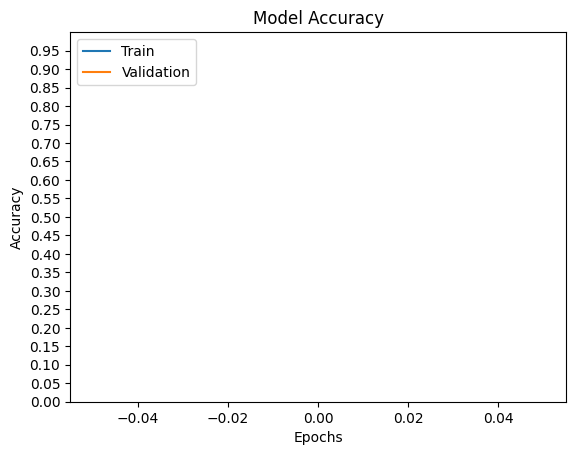

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylim(0.0,1.0)
plt.yticks(np.arange(0.0,1.0,0.05))
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

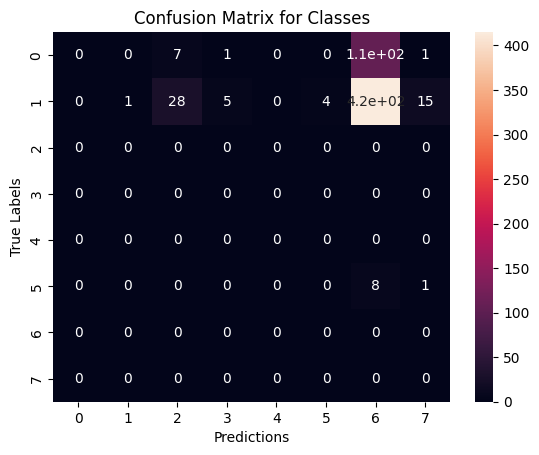

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(validation_dataset, verbose=0)
y_classes = predictions.argmax(axis=-1)
sns.heatmap(tf.math.confusion_matrix(
    df['class_num'][5800:],
    y_classes,
    num_classes=8,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
), annot=True)
plt.ylabel('True Labels')
plt.xlabel('Predictions')
plt.title('Confusion Matrix for Classes')
plt.show();

In [ ]:
print(y_classes)

[6 6 6 6 6 6 6 6 6 6 6 6 6 2 6 6 6 5 6 6 6 6 6 6 6 3 6 6 6 6 6 6 6 6 2 6 2
 6 6 6 6 6 6 6 7 7 6 6 6 6 6 6 6 6 6 6 6 6 6 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 6 6 6 6 6 6 6 7 6 6 6 6 6 6 7 3 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 2 2 6 6 6 6 6 6 6 6 6 2 6 6 7 6 6 6 6 2 6 2 2 3 6 6 6 7 6 6 6 6 6
 6 6 7 6 6 6 6 6 6 6 6 6 2 6 6 6 6 2 6 6 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 2 6 6 6 6 6 3 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 6 6 6
 6 6 6 6 6 6 6 6 6 7 6 6 6 6 6 6 6 2 6 6 6 6 6 6 6 6 6 6 6 6 2 6 6 6 6 6 6
 6 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 6 6 6 6 6 6 3 2 6 6 6 6 6 6 6 6 6
 2 6 6 6 7 6 5 6 6 6 6 6 6 6 6 6 6 6 6 2 6 6 2 2 6 6 6 6 6 6 1 6 6 2 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 6 2 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 3 6 7 2 6 2 

In [ ]:
print(df[5800:])

        ID  Patient Age Patient Sex    Left-Fundus    Right-Fundus  \
5800  4012           56      Female  4012_left.jpg  4012_right.jpg   
5801  4013           46        Male  4013_left.jpg  4013_right.jpg   
5802  4014           60      Female  4014_left.jpg  4014_right.jpg   
5803  4015           65      Female  4015_left.jpg  4015_right.jpg   
5804  4016           35      Female  4016_left.jpg  4016_right.jpg   
...    ...          ...         ...            ...             ...   
6387  4686           63        Male  4686_left.jpg  4686_right.jpg   
6388  4688           42        Male  4688_left.jpg  4688_right.jpg   
6389  4689           54        Male  4689_left.jpg  4689_right.jpg   
6390  4690           57        Male  4690_left.jpg  4690_right.jpg   
6391  4784           58        Male  4784_left.jpg  4784_right.jpg   

                               Left-Diagnostic Keywords  \
5800  mild nonproliferative retinopathy，hypertensive...   
5801             moderate non proliferati